In [1]:
import os
os.getcwd()

'c:\\Users\\conno\\AppData\\Local\\Programs\\projects\\google_capstone'

In [2]:
os.chdir('c:\\Users\\conno\\AppData\\Local\\Programs\\Python\\Python311\\lib\\site-packages')

In [3]:
# For data manipulation
import numpy as np
import pandas as pd


# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree
from sklearn.utils import resample

# For saving models
import pickle

In [4]:
# There is a panda function that producing a 'FutureWarning'
import warnings


warnings.filterwarnings("ignore", category=FutureWarning, )

**Objective**
- Employee retention
    - In order to do this, I will analyze data collected by the HR department to build predictive model(s) that will help answer the question "what's likely to make an employee leave the company?"

In [5]:
# Defining filepath and loading the csv into dataframe
path = r"C:\Users\conno\AppData\Local\Programs\projects\google_capstone\HR_capstone_dataset.csv"
df = pd.read_csv(path)
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


- No null or missing values in the dataset and it initally looks like all the values are the correct data types.

In [7]:
df = df.rename(columns={'Work_accident': 'work_accident',
                          'average_montly_hours': 'average_monthly_hours',
                          'time_spend_company': 'tenure',
                          'Department': 'department'})

In [8]:
df.duplicated().sum()

3008

- Significant amount of duplicates. Investigate further

In [9]:
df[df.duplicated()].head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
396,0.46,0.57,2,139,3,0,1,0,sales,low
866,0.41,0.46,2,128,3,0,1,0,accounting,low
1317,0.37,0.51,2,127,3,0,1,0,sales,medium
1368,0.41,0.52,2,132,3,0,1,0,RandD,low
1461,0.42,0.53,2,142,3,0,1,0,sales,low


In [10]:
df1 = df.drop_duplicates()

In [11]:
print(df1['left'].value_counts())
print(df1['left'].value_counts(normalize=True))

left
0    10000
1     1991
Name: count, dtype: int64
left
0    0.833959
1    0.166041
Name: proportion, dtype: float64


- 1 means true 0 means false so in this instance there are 3571 individuals who left the company
- 1,991 out of 10,000, or 20 %, of employees are leaving to work somehwere else

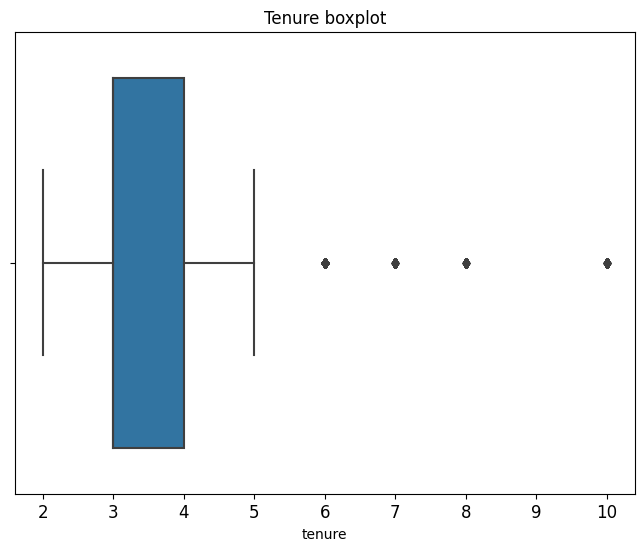

In [12]:
plt.figure(figsize=(8,6))
plt.title('Tenure boxplot', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=df1['tenure'])
plt.show()

In [13]:
# There seem to be a number of outliers. I am going to calculate the quartiles and then count the outliers for a better understanding on how to handle them.

quartile_25 = df1['tenure'].quantile(.25)
quartile_75 = df1['tenure'].quantile(.75)

iqr = quartile_75 - quartile_25

upper_limit = quartile_75 + 1.5 * iqr
lower_limit = quartile_25 - 1.5 * iqr

print("Upper limit:", upper_limit)
print("Lower limit:", lower_limit)

outliers = df1[(df1['tenure'] > upper_limit) | (df1['tenure'] < lower_limit)]

print("Number of outliers:", len(outliers))

Upper limit: 5.5
Lower limit: 1.5
Number of outliers: 824


*I'm going to proceede without dropping the outliers for now.*

- With the inital data processing and tranformations done, it's time to start visualizing and charting the data.

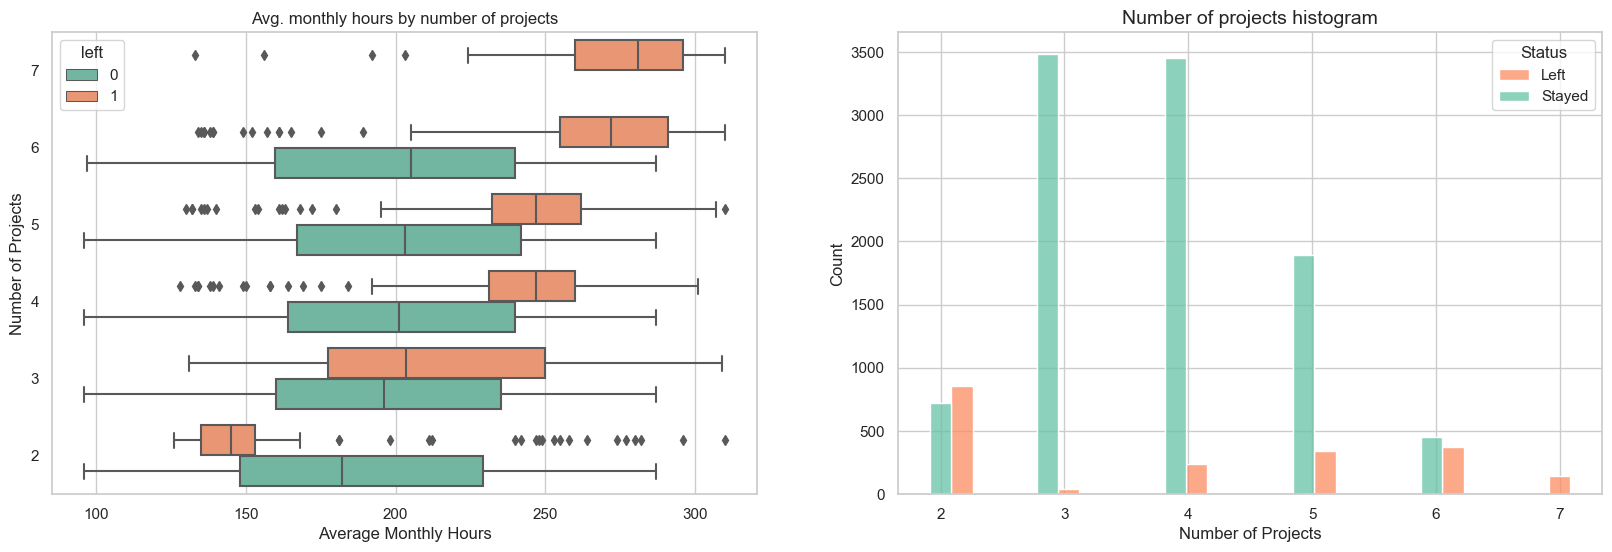

In [14]:
sns.set_theme(style='whitegrid', palette='Set2')

fig, ax = plt.subplots(1, 2, figsize=(20, 6))

sns.boxplot(data=df1, x='average_monthly_hours', y='number_project', hue='left', orient='h', ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title("Avg. monthly hours by number of projects", size='12')
ax[0].set_xlabel('Average Monthly Hours')
ax[0].set_ylabel('Number of Projects')

sns.histplot(data=df1, x='number_project', hue='left', multiple='dodge', shrink=2, ax=ax[1])
ax[1].set_title('Number of projects histogram', fontsize='14')
ax[1].set_xlabel('Number of Projects')
ax[1].set_ylabel('Count')
plt.legend(title='Status', labels=['Left', 'Stayed'])

plt.show()

In [15]:
# validating that all employees with 7 projects left
df1[df1['number_project']==7]['left'].value_counts()

left
1    145
Name: count, dtype: int64

In [16]:
tenure_stay = df1[df1['left']==0]
tenure_left = df1[df1['left']==1]
tenure_left.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


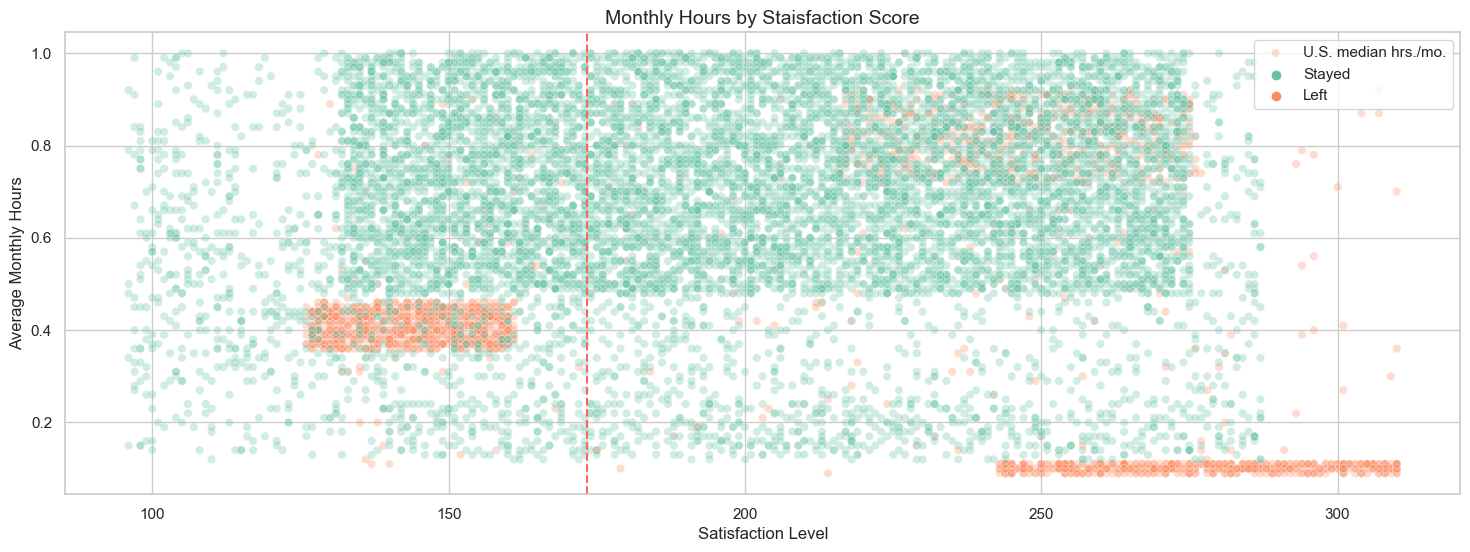

In [17]:
plt.figure(figsize=(18,6))
sns.scatterplot(data=df1, x='average_monthly_hours', y='satisfaction_level', alpha=.3, hue='left')
plt.xlabel('Satisfaction Level')
plt.ylabel('Average Monthly Hours')
plt.axvline(x=173.3, color='#ff6361', label='U.S. median hrs./mo.', ls='--' )
plt.legend(labels=['U.S. median hrs./mo.', 'Stayed', 'Left'])
plt.title('Monthly Hours by Staisfaction Score', fontsize='14');

- ### Key Insights
    - 300 hours a month seem high, espicially considering how many there are.
    - The red line represents the U.S. median hours worked per month.
    - Overall the average hours worked seems weird


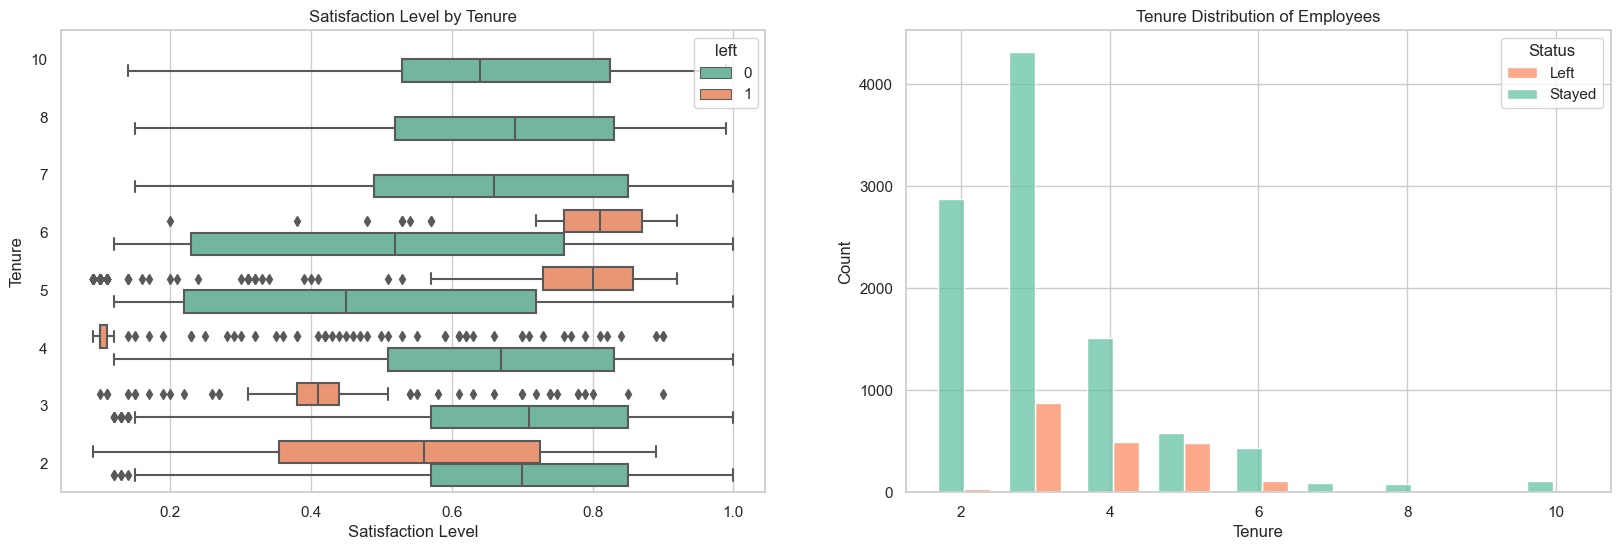

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

# Plot 1: Satisfaction level by tenure
sns.boxplot(data=df1, x='satisfaction_level', y='tenure', hue='left', orient='h', ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Satisfaction Level by Tenure', size='12')
ax[0].set_xlabel('Satisfaction Level')
ax[0].set_ylabel('Tenure')

# Plot 2: Employee histogram by tenure
sns.histplot(data=df1, x='tenure', hue='left', multiple='dodge', shrink=8, ax=ax[1])
ax[1].set_title('Tenure Distribution of Employees')
ax[1].set_xlabel('Tenure')
ax[1].set_ylabel('Count')

plt.legend(title='Status', labels=['Left', 'Stayed'])
plt.show()

In [19]:
df1.groupby(['left'])['satisfaction_level'].agg([np.mean, np.median])

,mean,median
left,,
0,0.667365,0.69
1,0.440271,0.41


---
- Employees that left fall were either:
    - Short tenure and dissatisfted employees
    - Long tenure and highly satisfed
- 4 year employees that left have a unusally low satisfaction score
- Very few employees leave if they after reaching 6 years of employement.

In [20]:
# Define short-tenured employees
tenure_short = df1[df1['tenure'] < 7]

# Define long-tenured employees
tenure_long = df1[df1['tenure'] > 6]

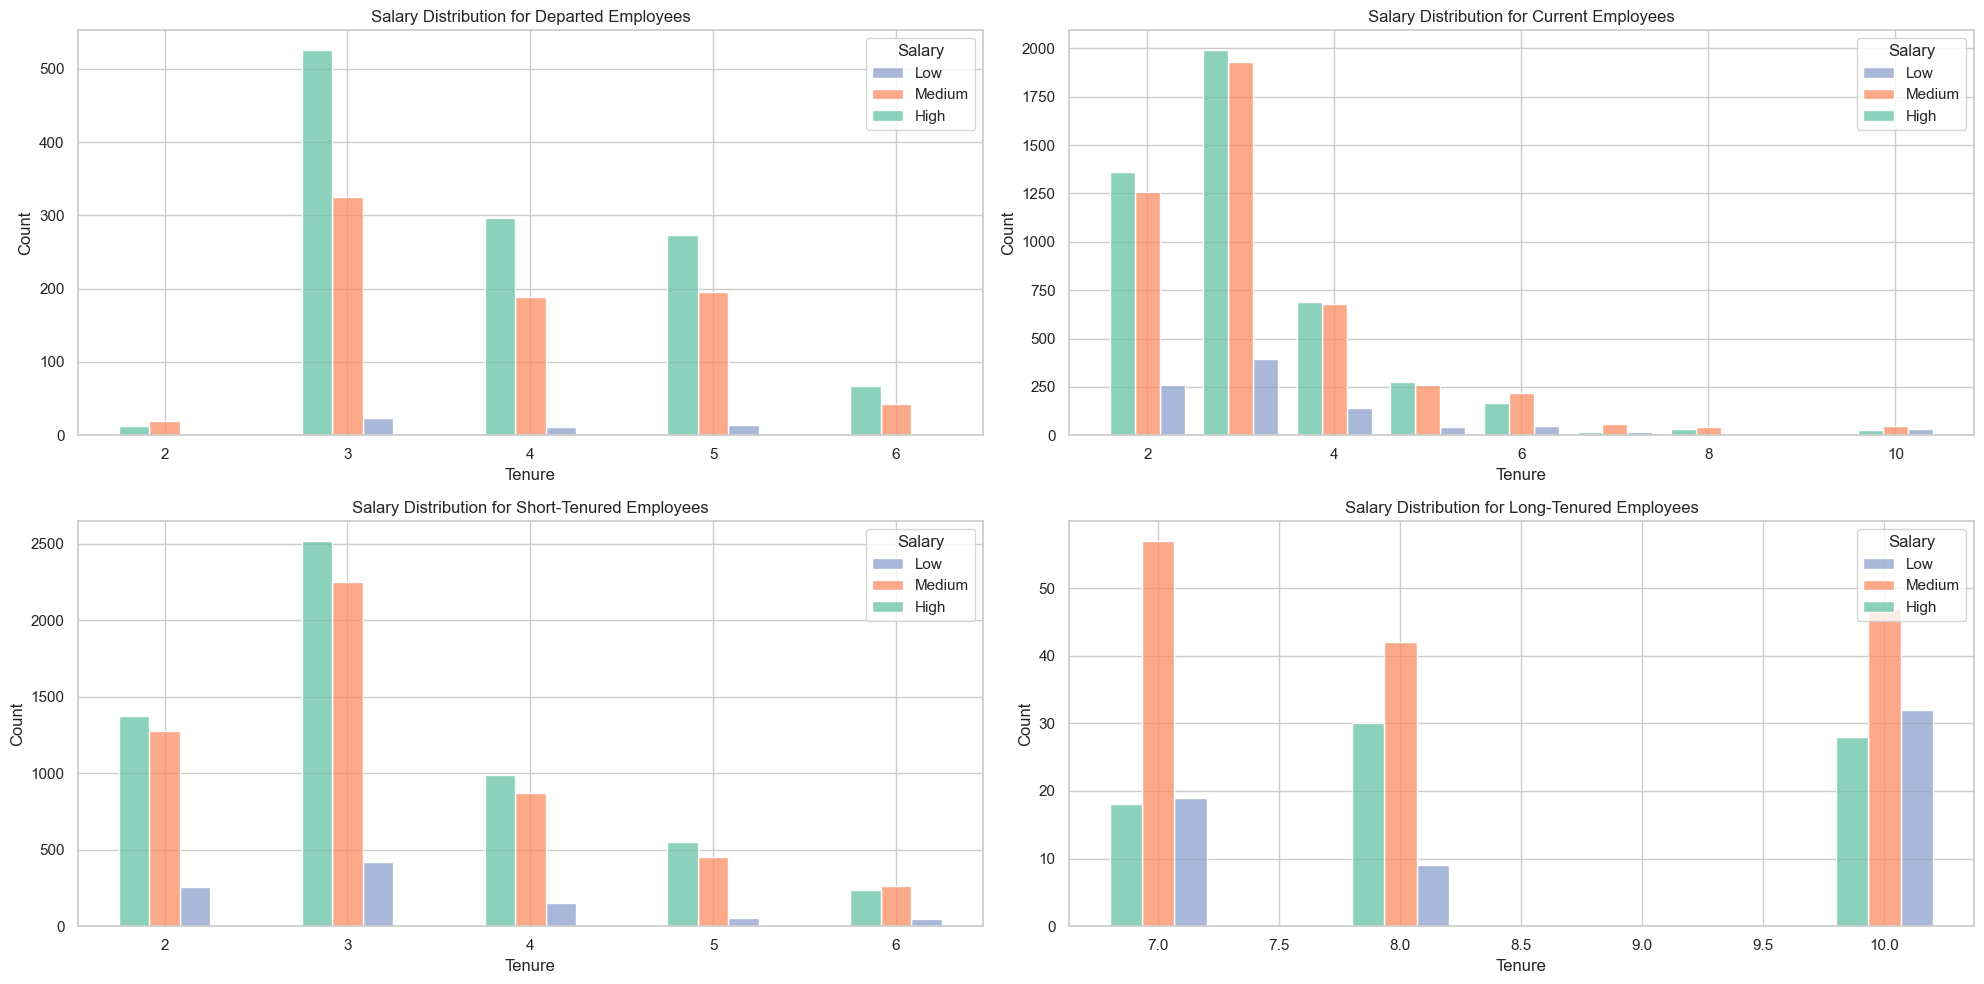

In [21]:
# Create a 2x2 grid of subplots
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

# Define a consistent color palette
color_palette = sns.color_palette("Set2")

# Plot 1: Salary histogram by employees that left
sns.histplot(data=tenure_left, x='tenure', hue='salary', discrete=1,
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.5 , ax=ax[0, 0])
ax[0, 0].set_title('Salary Distribution for Departed Employees')
ax[0, 0].set_xlabel('Tenure')
ax[0, 0].set_ylabel('Count')
ax[0, 0].legend(title='Salary', labels=['Low', 'Medium', 'High'], loc='upper right')

# Plot 2: Salary histogram by employees that stayed
sns.histplot(data=tenure_stay, x='tenure', hue='salary', discrete=1,
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.8 , ax=ax[0, 1])
ax[0, 1].set_title('Salary Distribution for Current Employees')
ax[0, 1].set_xlabel('Tenure')
ax[0, 1].set_ylabel('Count')
ax[0, 1].legend(title='Salary', labels=['Low', 'Medium', 'High'], loc='upper right')

# Plot 3: Salary histogram by tenure: short-tenured people
sns.histplot(data=tenure_short, x='tenure', hue='salary', discrete=1, 
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.5, ax=ax[1, 0])
ax[1, 0].set_title('Salary Distribution for Short-Tenured Employees')
ax[1, 0].set_xlabel('Tenure')
ax[1, 0].set_ylabel('Count')
ax[1, 0].legend(title='Salary', labels=['Low', 'Medium', 'High'], loc='upper right')

# Plot 4: Salary histogram by tenure: long-tenured people
sns.histplot(data=tenure_long, x='tenure', hue='salary', discrete=1, 
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.4, ax=ax[1, 1])
ax[1, 1].set_title('Salary Distribution for Long-Tenured Employees')
ax[1, 1].set_xlabel('Tenure')
ax[1, 1].set_ylabel('Count')
ax[1, 1].legend(title='Salary', labels=['Low', 'Medium', 'High'], loc='upper right')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [22]:
df1["department"].value_counts()

department
sales          3239
technical      2244
support        1821
IT              976
RandD           694
product_mng     686
marketing       673
accounting      621
hr              601
management      436
Name: count, dtype: int64

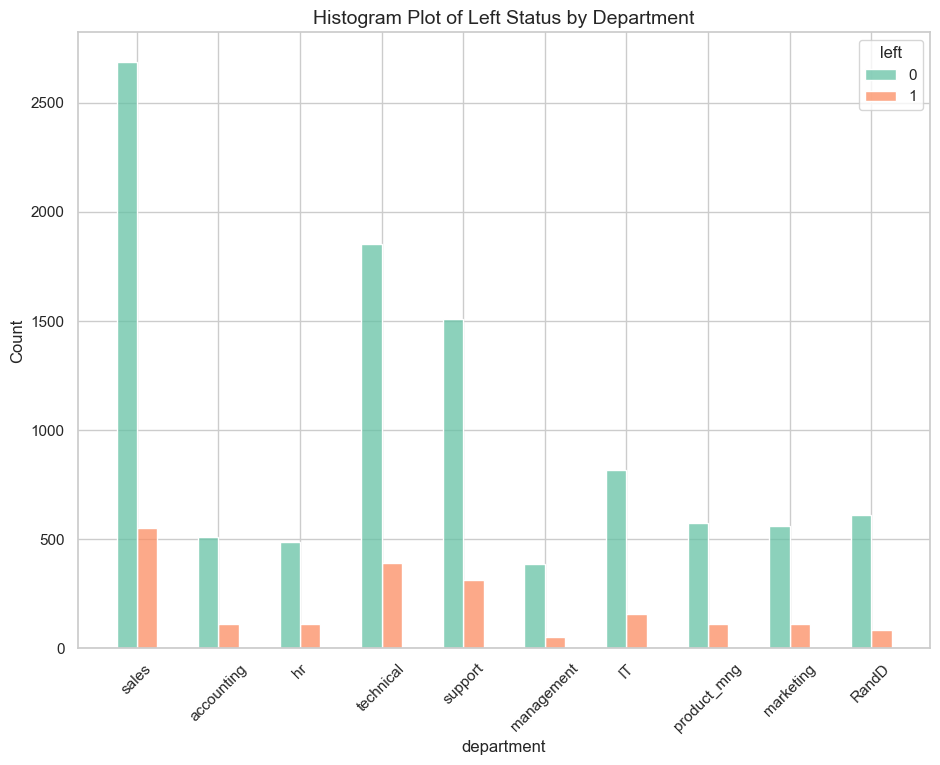

In [23]:
plt.figure(figsize=(11,8))
sns.histplot(data=df1, x='department', hue='left', discrete=1, 
             hue_order=[0, 1], multiple='dodge', shrink=.5)
plt.xticks(rotation=45)
plt.title('Histogram Plot of Left Status by Department', fontsize=14);


In [24]:
df1.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [25]:
df1.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

In [26]:
# dropping categorical columns in order to plot a heatmap
df2 = df1.drop(['department', 'salary'], axis=1)

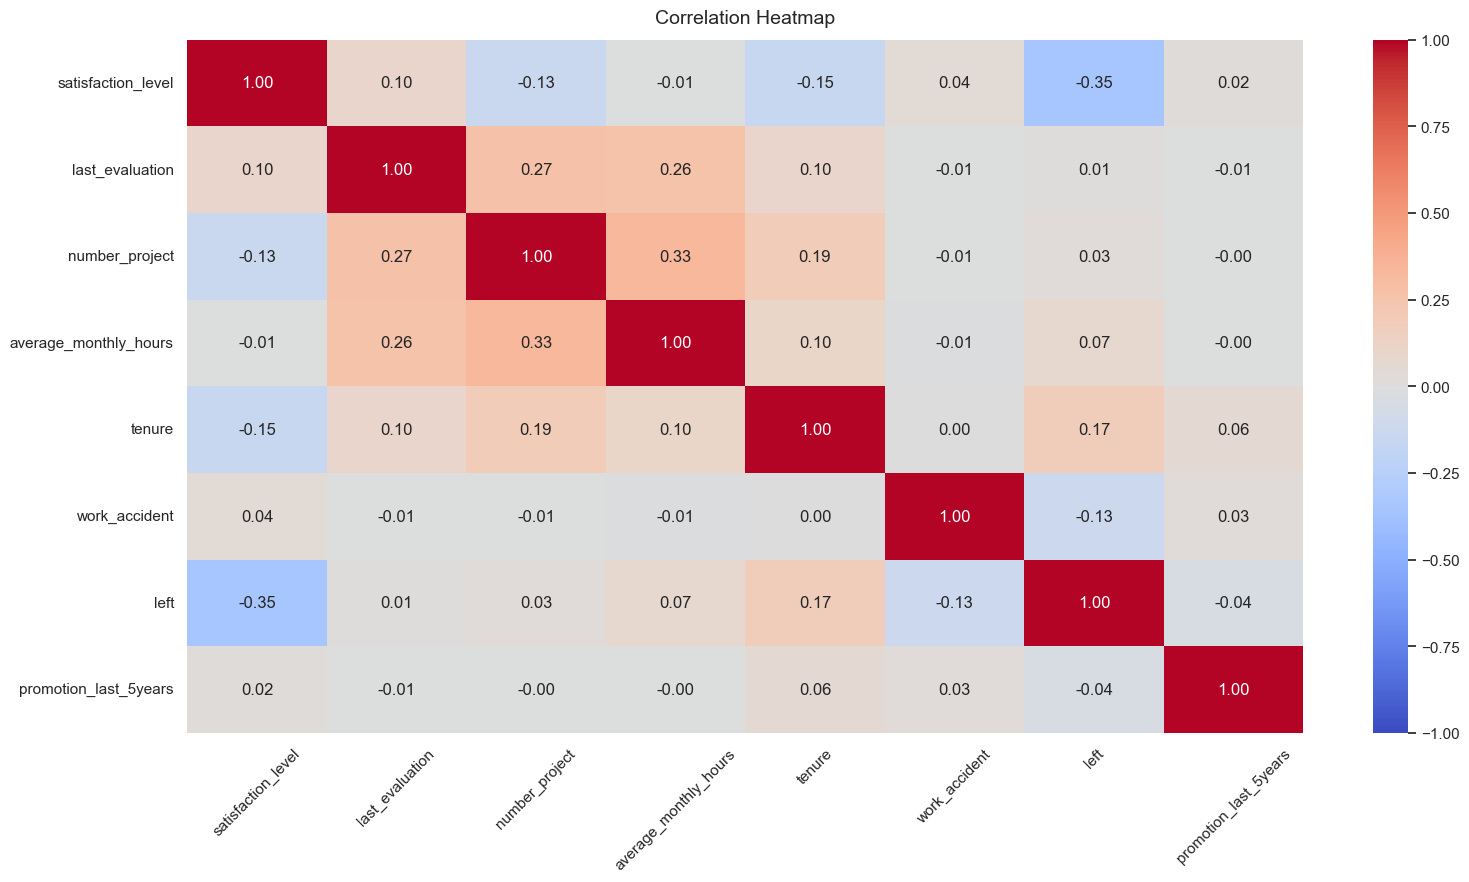

In [27]:
# In this heatmap, look for patterns of correlation:
# - Positive values (closer to 1) indicate a strong positive relationship.
# - Negative values (closer to -1) indicate a strong negative relationship.
# - Values close to 0 suggest weak or no correlation between variables.
# Pay attention to the color intensity and direction to identify relationships.

plt.figure(figsize=(18, 9))
heatmap = sns.heatmap(df2.corr(), vmin=-1, vmax=1, annot=True, fmt='.2f',cmap=sns.color_palette("coolwarm", as_cmap=True))
plt.xticks(rotation=45)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);

## Data Summary

### Dataset Overview

The dataset contains employee attributes and employment status information, including satisfaction levels, project counts, working hours, tenure, accidents, promotions, departments, and salaries.

### Key Insights

- **Satisfaction Level**: Employee satisfaction varies, which may affect attrition.

- **Workload**: The number of projects and working hours could influence attrition.

- **Promotions**: Examining promotions in the last 5 years can reveal their impact on employee retention.

- **Department and Salary**: Analyzing department and salary levels can uncover compensation and career progression patterns.

## Next Steps
- Since we are trying to predict a binomail, left is either 1 or 0, I am going to build a **logistics regression model**

In [29]:
# Creating a dataframe w/ the two non-numerical variables encoded to allow these variables to be inlcuded in the model
df_enc = df1.copy()

df_enc['salary'] = (
    df_enc['salary'].astype('category')
    .cat.set_categories(['low', 'medium', 'high'])
    .cat.codes
)

df_enc = pd.get_dummies(df_enc, drop_first=False)

df_enc.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
1,0.80,0.86,5,262,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


In [30]:
# Creating new variable w/ outliers in 'tenure' removed
df_logreg = df_enc[(df_enc['tenure'] >= lower_limit) & (df_enc['tenure'] <= upper_limit)]

df_logreg.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
5,0.41,0.50,2,153,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


In [31]:
# Declaring model X & y variables
y = df_logreg['left']
print(y)

X = df_logreg.drop('left', axis=1)
print(X)

0        1
2        1
3        1
4        1
5        1
        ..
11985    0
11986    0
11987    0
11992    0
11999    0
Name: left, Length: 11167, dtype: int64
       satisfaction_level  last_evaluation  number_project  \
0                    0.38             0.53               2   
2                    0.11             0.88               7   
3                    0.72             0.87               5   
4                    0.37             0.52               2   
5                    0.41             0.50               2   
...                   ...              ...             ...   
11985                0.72             0.64               4   
11986                0.48             0.50               5   
11987                0.19             0.79               4   
11992                0.62             0.85               3   
11999                0.50             0.73               4   

       average_monthly_hours  tenure  work_accident  promotion_last_5years  \
0               

In [32]:
# Splitting the data into training & test sets.
# Stratifying the y variable due to class imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y, random_state=40)

In [33]:
log_mod = LogisticRegression(random_state=40, max_iter=500).fit(X_train, y_train)

In [34]:
y_pred = log_mod.predict(X_test)

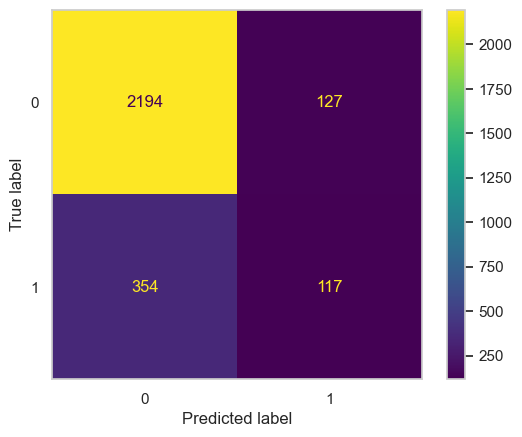

In [36]:
log_cm = confusion_matrix(y_test, y_pred, labels=log_mod.classes_)

log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm,
                                  display_labels=log_mod.classes_)

log_disp.plot(values_format='')
plt.grid(0)
plt.show()

The upper-left quadrant displays the number of true negatives.
The upper-right quadrant displays the number of false positives.
The bottom-left quadrant displays the number of false negatives.
The bottom-right quadrant displays the number of true positives.

True negatives: The number of people who did not leave that the model accurately predicted did not leave.

False positives: The number of people who did not leave the model inaccurately predicted as leaving.

False negatives: The number of people who left that the model inaccurately predicted did not leave

True positives: The number of people who left the model accurately predicted as leaving

A perfect model would yield all true negatives and true positives, and no false negatives or false positives.

In [37]:
df_logreg['left'].value_counts(normalize=True)

left
0    0.831468
1    0.168532
Name: proportion, dtype: float64

In [38]:
# Create classification report for logistic regression model
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.86      0.95      0.90      2321
    Predicted would leave       0.48      0.25      0.33       471

                 accuracy                           0.83      2792
                macro avg       0.67      0.60      0.61      2792
             weighted avg       0.80      0.83      0.80      2792



The classification report above shows that the logistic regression model achieved a precision of 80%, recall of 82%, f1-score of 80% (all weighted averages), and accuracy of 82%.

Since the goal is to predict employees who leave, this is model isn't usable and a new approach is recomended. 